In [1]:
%load_ext autoreload
%autoreload 2

# load dependencies'
import pandas as pd
import geopandas as gpd
import numpy as np
import seaborn as sns
from datetime import datetime
import pysal
pd.options.mode.chained_assignment = None 
from geofeather import to_geofeather, from_geofeather
from matplotlib import pyplot as plt

from envirocar import TrackAPI, DownloadClient, BboxSelector, ECConfig

# create an initial but optional config and an api client
config = ECConfig()
track_api = TrackAPI(api_client=DownloadClient(config=config))

C:\Anaconda\envs\python3\lib\site-packages\pysal\__init__.py:65: VisibleDeprecationWarning: PySAL's API will be changed on 2018-12-31. The last release made with this API is version 1.14.4. A preview of the next API version is provided in the `pysalnext` package. The API changes and a guide on how to change imports is provided at https://migrating.pysal.org
  ), VisibleDeprecationWarning)


In [2]:
track_df = from_geofeather('Data/Monchengladbach.feather')
track_df.head()

C:\Anaconda\envs\python3\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


index                        id                 time  \
0      0  5b46294f44ea850910a1c1e0  2018-07-11T06:07:23   
1      1  5b46294f44ea850910a1c1e2  2018-07-11T06:07:28   
2      2  5b46294f44ea850910a1c1e3  2018-07-11T06:07:33   
3      3  5b46294f44ea850910a1c1e4  2018-07-11T06:07:38   
4      4  5b46294f44ea850910a1c1e5  2018-07-11T06:07:43   

                   geometry  GPS Bearing.value GPS Bearing.unit  \
0  POINT (6.41455 51.20328)         117.943870              deg   
1  POINT (6.41512 51.20308)         115.088323              deg   
2  POINT (6.41564 51.20299)         106.541059              deg   
3  POINT (6.41615 51.20291)          99.885196              deg   
4  POINT (6.41671 51.20282)         104.435649              deg   

   Intake Temperature.value Intake Temperature.unit  MAF.value MAF.unit  ...  \
0                 28.000001                       c  35.669282      l/s  ...   
1                 28.000000                       c  31.446508      l/s  ...   
2                 28.000000                       c  28.072108      l/s  ...   
3                 28.000000                       c  33.429661      l/s  ...   
4                 27.999999                       c  25.774274      l/s  ...   

   Consumption.value Consumption.unit  Throttle Position.value  \
0                NaN             None                      NaN   
1                NaN             None                      NaN   
2                NaN             None                      NaN   
3                NaN             None                      NaN   
4                NaN             None                      NaN   

  Throttle Position.unit  track.appVersion track.touVersion  \
0                   None              None             None   
1                   None              None             None   
2                   None              None             None   
3                   None              None             None   
4                   None              None             None   

   O2 Lambda Voltage.value O2 Lambda Voltage.unit  O2 Lambda Voltage ER.value  \
0                      NaN                   None                         NaN   
1                      NaN                   None                         NaN   
2                      NaN                   None                         NaN   
3                      NaN                   None                         NaN   
4                      NaN                   None                         NaN   

  O2 Lambda Voltage ER.unit  
0                      None  
1                      None  
2                      None  
3                      None  
4                      None  

[5 rows x 55 columns]

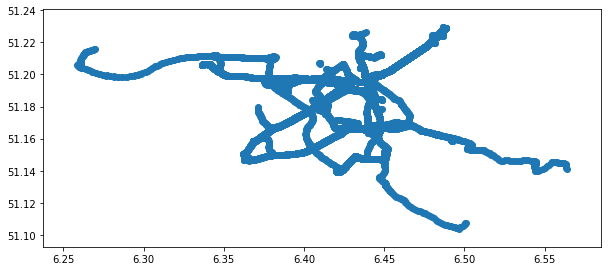

In [3]:
track_df.plot(figsize=(10, 12))

In [4]:
#fixing the speed values
#compare two speed values - GPS Speed.value and Speed.value
track_df['diff']= track_df ['GPS Speed.value']-track_df['Speed.value']
track_df['diff'].describe()

count    22005.000000
mean        -0.003303
std          3.095139
min        -48.999999
25%         -0.388510
50%          0.000000
75%          0.940252
max         58.100833
Name: diff, dtype: float64

C:\Anaconda\envs\python3\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Anaconda\envs\python3\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


(array([6.0000e+00, 1.0000e+01, 7.8000e+01, 5.6900e+02, 2.0735e+04,
        5.7700e+02, 2.2000e+01, 4.0000e+00, 2.0000e+00, 2.0000e+00]),
 array([-48.99999927, -38.28991608, -27.5798329 , -16.86974971,
         -6.15966653,   4.55041666,  15.26049984,  25.97058303,
         36.68066621,  47.3907494 ,  58.10083258]),
 <a list of 10 Patch objects>)

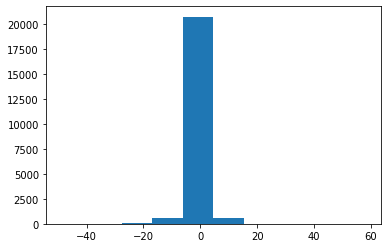

In [5]:
plt.hist(track_df['diff'])

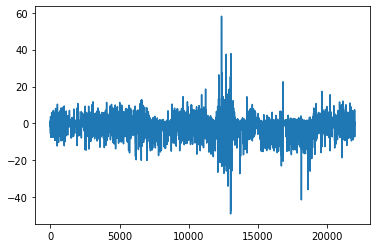

In [6]:
#looking for small GPS speed which may mean they are stopping
# df[(df.a != -1) & (df.b != -1)]
track_df[['GPS Speed.value','Speed.value','diff']][track_df['GPS Speed.value'] <5]
plt.plot(track_df['diff'])

In [7]:
from pysal import esda
import numpy as np

from pyproj import CRS
from pyproj import Transformer

inputCRS = CRS.from_epsg(4326)
outputCRS = CRS.from_epsg(25832)
transformer = Transformer.from_crs(inputCRS, outputCRS)
def project(a,b):
    return transformer.transform(a, b)

count    4972.000000
mean        3.518101
std         0.918240
min         0.000000
25%         3.000000
50%         3.000000
75%         5.000000
max        10.000000
Name: time_diff, dtype: float64

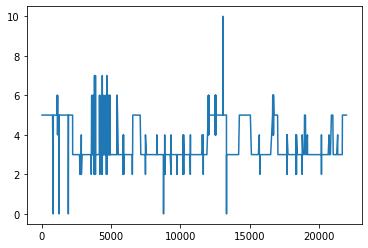

In [8]:
## select stopping times data
df_speed = track_df

# convert the date column to datetime type
df_speed['time_datetime'] = pd.to_datetime(df_speed['time'], format = "%Y-%m-%dT%H:%M:%S")
df_speed['time_diff'] = (df_speed['time_datetime'] - df_speed['time_datetime'].shift()).fillna(pd.Timedelta('0 days'))
df_speed['time_diff'] = df_speed['time_diff'].apply(lambda x: x.total_seconds())

##identify first record in each track and assing a default value of 0
tracks_id = (df_speed['id'].groupby(df_speed['track.id']).nth(0)).tolist()
df_speed['time_diff'][df_speed['id'].isin(tracks_id)] = 0

### select tracks with speed = 0
df_speed = df_speed[df_speed['Speed.value'] == 0]

### plot times
plt.plot(df_speed['time_diff'])
df_speed['time_diff'].describe()

count    4296.000000
mean        4.071695
std         2.751057
min         0.000000
25%         3.000000
50%         3.000000
75%         5.000000
max        40.000000
Name: time_diff, dtype: float64

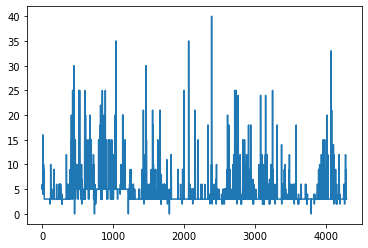

In [9]:
##get coordinates
df_speed['lat'] = df_speed['geometry'].apply(lambda coord: coord.y)
df_speed['lng'] = df_speed['geometry'].apply(lambda coord: coord.x)
df_speed.reset_index()

## group by location
data_speed = df_speed.groupby(['lat','lng'])[['time_diff']].sum().reset_index()

### plot times
plt.plot(data_speed['time_diff'])
data_speed['time_diff'].describe()

In [10]:
### calculate weights for getis ord
coords = [project(row['lat'], row['lng']) for index, row in data_speed.iterrows()]
w = pysal.weights.DistanceBand(coords, threshold= 20)
w
# coords

C:\Anaconda\envs\python3\lib\site-packages\pysal\weights\weights.py:189: UserWarning: There are 53 disconnected observations
  warnings.warn("There are %d disconnected observations" % ni)
C:\Anaconda\envs\python3\lib\site-packages\pysal\weights\weights.py:190: UserWarning: Island ids: 0, 236, 245, 366, 384, 432, 459, 469, 470, 636, 700, 733, 745, 757, 781, 817, 827, 829, 852, 865, 902, 903, 960, 1153, 1154, 1173, 1215, 1216, 1217, 1368, 1521, 1604, 1605, 1775, 2004, 2075, 2483, 2498, 2796, 2841, 2854, 2915, 3122, 3192, 3215, 3236, 3249, 3420, 3936, 3937, 3944, 4213, 4233
  warnings.warn("Island ids: %s" % ', '.join(str(island) for island in self.islands))


In [11]:
#getisOrdGlobal = esda.getisord.G(data_speed['time_sec'], w)
getisOrdLocal = esda.getisord.G_Local(data_speed['time_diff'], w, transform='B')
getisOrdLocal.Zs

C:\Anaconda\envs\python3\lib\site-packages\pysal\esda\getisord.py:434: RuntimeWarning: invalid value encountered in true_divide
  self.Zs = (self.Gs - self.EGs) / np.sqrt(self.VGs)
C:\Anaconda\envs\python3\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
C:\Anaconda\envs\python3\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
C:\Anaconda\envs\python3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1827: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= np.asarray(_b)) & cond0


array([        nan,  0.33761838,  0.70102034, ..., -1.29384669,
       -1.29384669, -1.29384669])

In [12]:
data_speed['z_score'] = getisOrdLocal.Zs
data_speed['p_value'] = getisOrdLocal.p_norm
# data_speed[data_speed['p_value'] < 0.05]
# data_speed[data_speed['z_score'] == 0]
# data_speed_hotspots = data_speed[data_speed['z_score'] > 0 and data_speed['p_value'] < 0.05]
# hotspots1 = data_speed[data_speed['p_value'] < 0.05]
#query
# hotspot = data_speed.query('z_score > 0 & p_value < 0.05')
#two conditions
hotspot = data_speed[(data_speed.z_score > 0) & (data_speed.p_value <=0.05)]
coldspot = data_speed[(data_speed.z_score < 0) & (data_speed.p_value <=0.05)]

hotspot

lat       lng  time_diff   z_score   p_value
3     51.131155  6.450722        5.0  2.794497  0.002599
4     51.131156  6.450722        5.0  2.794497  0.002599
5     51.131157  6.450723        5.0  2.794497  0.002599
6     51.131157  6.450723        5.0  2.794497  0.002599
7     51.131275  6.450733        5.0  2.794497  0.002599
...         ...       ...        ...       ...       ...
4117  51.223305  6.482229        3.0  1.997214  0.022901
4118  51.223305  6.482229        2.0  2.043518  0.020501
4119  51.223306  6.482229        3.0  1.997214  0.022901
4120  51.223306  6.482229        3.0  1.997214  0.022901
4121  51.223306  6.482229        3.0  1.997214  0.022901

[465 rows x 5 columns]

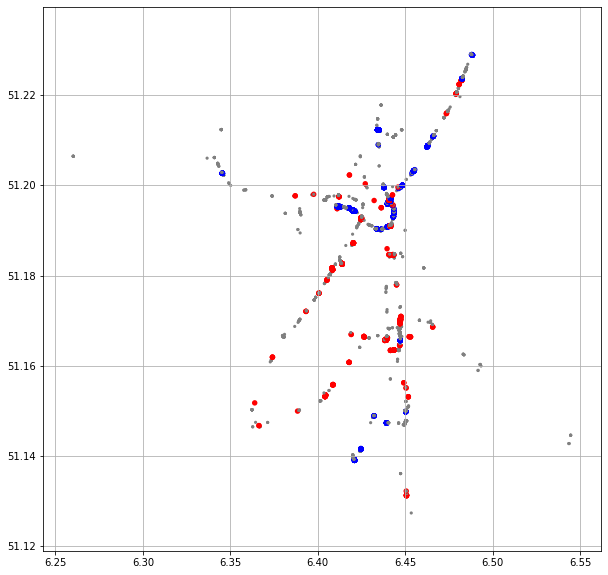

In [13]:
from matplotlib import pyplot as plt
#>1.96 hot spots
#<-1.96 cold spots
from matplotlib import colors as cls

f, axarr = plt.subplots(1, figsize=(10,10))
total_range = cls.Normalize(vmin = - 1.96, vmax = 1.96)

def pltcolor(p_value, z_score, confidence):
    cols=[]
    size=[]
    for p, z in zip(p_value, z_score):
        if p < confidence:
            if z > 0:
                cols.append('red')
                size.append(30)
            else:
                cols.append('blue')
                size.append(30)
        else:
            cols.append('grey')
            size.append(10)
    return cols , size


# Create the colors list using the function above
cols, sizes = pltcolor(data_speed['p_value'], data_speed['z_score'], 0.05)

plt.scatter(x=data_speed['lng'], y=data_speed['lat'], s=sizes, c=cols, lw = 0) #Pass on the list created by the function here
plt.grid(True)
plt.show()

In [14]:
import folium

lats = data_speed['lat']
lngs = data_speed['lng']

#z-value
z = data_speed['z_score']
p = data_speed['p_value']

avg_lat = sum(lats) / len(lats)
avg_lngs = sum(lngs) / len(lngs)

m = folium.Map(location=[avg_lat - 0.25, avg_lngs], tiles = 'Stamen Terrain', zoom_start=9)

color, sizes = pltcolor(p, z, 0.05)
time = data_speed['time_diff']
def makepopup(t):
    return str(t) + ' sec'

for lat,lng,c,s,t in zip(lats, lngs, color, sizes, time):
    radius = coords[2]
    folium.CircleMarker([lat,lng], color = c, radius = s/3, fill = c, popup = makepopup(t)).add_to(m)
m